In [1]:
import numpy as np

import torch
import torchvision
import torch.optim as optim
import torch.nn as nn

import matplotlib.pyplot as plt
import librosa
import librosa.display
#import IPython.display as ipd

import tqdm
from tqdm import tqdm

import random
import pickle

from sklearn import metrics
from sklearn.metrics import roc_curve, auc

In [2]:
def makeWindows(data, numWindows):
    windows = []
    intervalLength = int(430 / numWindows)
    for mspec in tqdm(range(len(data))):
        start = 0
        end = intervalLength
        for interval in range(numWindows):
            melspectrogram = data[mspec]
            window = melspectrogram[:,start:end]
            windows.append(window)
            start += intervalLength
            end += intervalLength
    return windows
        
def makeWindows2(data, numWindows): #makes the windows with the metadata to amke it reconstructable
    windows = []
    classifiers = {}
    intervalLength = int(430 / numWindows)
    for mspec in tqdm(range(len(data))):
        start = 0
        end = intervalLength
        classifiers[mspec] = data[mspec][1]
        for interval in range(numWindows):
            melspectrogram = data[mspec][0]
            window = melspectrogram[:,start:end]
            windows.append([window, mspec, interval])
            start += intervalLength
            end += intervalLength
    return windows, classifiers

def makeWindows3(data, numWindows):
    windows = []
    intervalLength = int(430 / numWindows)
    for mspec in tqdm(range(len(data))):
        start = 0
        end = intervalLength
        for interval in range(numWindows):
            melspectrogram = data[mspec][0]
            window = melspectrogram[:,start:end]
            windows.append([window, mspec, interval])
            start += intervalLength
            end += intervalLength
    return windows

def makeWindows4(data, numWindows): #makes the windows with the metadata to amke it reconstructable, takes in a singular window
    windows = []
    intervalLength = int(430 / numWindows)
    start = 0
    end = intervalLength
    classifier = data[1]
    melspectrogram = data[0]
    for interval in range(numWindows):
        window = melspectrogram[:,start:end]
        windows.append([window, interval])
        start += intervalLength
        end += intervalLength
        
    npWindows = np.array([]).reshape(0,1,11,10)
    for j in range(len(windows)):
        npWindows = np.vstack([npWindows, windows[j][0].reshape(-1,1,11,10)])
    return npWindows, classifier

def sortWindows(arr):#sorts from least to greatest in terms of the "mel-order"
    for mspec in range(len(arr)):
        for mspec2 in range(mspec, len(arr)):
            if arr[mspec][2] > arr[mspec2][2]:
                temp = arr[mspec]
                arr[mspec] = arr[mspec2]
                arr[mspec2] = temp
    return arr

def reconstruct(arr, numWindows, size): #reconstructs the Mel spectrograms after being window sliced and shuffled
    arr = arr.tolist()
    melspectrograms = []
    allRecon = []
    for melID in tqdm(range(size)):
        mspec = []
        for a in range(len(arr)):
            print(a)
            if arr[a][1] == melID:
                mspec.append(arr[a])
        sortWindows(mspec)
        mspec = np.array(mspec)
        whole = mspec[0][0]
        for time in range(1,numWindows):
            whole = np.concatenate((whole, mspec[time][0]), axis=1)
        whole = whole.tolist()
        allRecon.append(whole)
    return allRecon

def reconstruct2(numpyArray, numWindows): #reconstructs the Mel spectrograms after being window sliced and shuffled
    numpyArray = numpyArray.tolist()
    #numpyArray = sortWindows2(numpyArray)
    mspec = np.array(numpyArray)
    whole = mspec[0].reshape(11,10)
    for time in range(1,numWindows):
        whole = np.concatenate((whole, mspec[time].reshape(11,10)), axis=1)
    return whole

def sortWindows2(arr):#sorts from least to greatest in terms of the "mel-order", takes in a python list
    for mspec in range(len(arr)):
        for mspec2 in range(mspec, len(arr)):
            if arr[mspec][1] > arr[mspec2][1]:
                temp = arr[mspec]
                arr[mspec] = arr[mspec2]
                arr[mspec2] = temp
    return arr

In [3]:
class CAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential( #starting size: (11,10)
            nn.Conv2d(1,32,3), #input: 11, 10 -> 9, 8
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3), #input: 4, 4 -> 2,2
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2) #input: 2, 2 -> 1, 1
            #final: 1, 1
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2), #input: 1,1 -> 3,3
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 6, stride=2, output_padding = (1,0)) #input: 3, 3 -> 11,10
            
            #final: 11,10
        )
        
    def forward(self,x):
        x = self.encoder(x)
        x=self.decoder(x)
        return x

In [4]:
# print(len(allNormal),len(allAnomaly))

In [5]:
numWindows = 43

  3%|▎         | 51/1875 [00:00<00:07, 257.41it/s]

1875


100%|██████████| 1875/1875 [00:06<00:00, 275.48it/s]
No handles with labels found to put in legend.


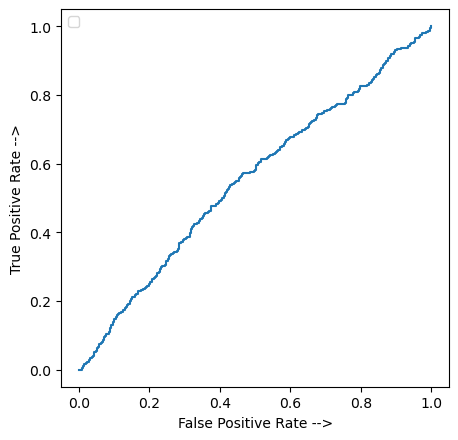

0.551564406779661


In [85]:
allNormal = np.load("dev_test_fanNormal.npy", allow_pickle=True)
allAnomaly = np.load("dev_test_fanAnomaly.npy", allow_pickle=True)

test = allNormal[:]
test = test.tolist()

for i in allAnomaly:
    test.append(i)

print(len(test))

model = pickle.load(open('fan_1.pt', 'rb'))
criterion = nn.MSELoss()
lossDictionary = {}
val_acc = -1
val_loss = []
classifiers = []


# for data in tqdm(range(len(windows))):
#     window = torch.from_numpy(windows[data][0]).type(torch.float32)
#     output = model(window.view(-1,1,11,86))
#     loss = criterion(output.view(-1,1,11,86), window.view(-1,1,11,86))
#     val_loss.append(loss)
#     if lossDictionary.get(windows[data][1]) == None:
#         lossDictionary[windows[data][1]] = [loss.item()]
#     elif lossDictionary.get(windows[data][1]) != None:
#         lossDictionary[windows[data][1]].append(loss.item())
        
for data in tqdm(range(len(test))):
    windows, classifier = makeWindows4(test[data], numWindows)
    classifiers.append(classifier[0])
#     windows = np.array(windows)
    windows = torch.from_numpy(windows).type(torch.float32)
    output = model(windows.view(-1,1,11,10))
    mspec = reconstruct2(output.detach().numpy(), numWindows)
    loss = criterion(torch.from_numpy(mspec).type(torch.float32).view(-1,1,11,430), torch.from_numpy(test[data][0]).type(torch.float32).view(-1,1,11,430))
    val_loss.append(loss)
    lossDictionary[data] = loss.item()

val_loss = np.array(val_loss)
val_loss = val_loss * -1
fpr, tpr, thresholds = metrics.roc_curve(classifiers, val_loss)
    
#AUC-ROC Graph

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(fpr, tpr, linestyle='-')

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()
print(auc(fpr,tpr))

In [94]:
for i in range(400, 1875):
    print(f"{i}: {classifiers[i]}")

400: 0
401: 0
402: 0
403: 0
404: 0
405: 0
406: 0
407: 0
408: 0
409: 0
410: 0
411: 0
412: 0
413: 0
414: 0
415: 0
416: 0
417: 0
418: 0
419: 0
420: 0
421: 0
422: 0
423: 0
424: 0
425: 0
426: 0
427: 0
428: 0
429: 0
430: 0
431: 0
432: 0
433: 0
434: 0
435: 0
436: 0
437: 0
438: 0
439: 0
440: 0
441: 0
442: 0
443: 0
444: 0
445: 0
446: 0
447: 0
448: 0
449: 0
450: 0
451: 0
452: 0
453: 0
454: 0
455: 0
456: 0
457: 0
458: 0
459: 0
460: 0
461: 0
462: 0
463: 0
464: 0
465: 0
466: 0
467: 0
468: 0
469: 0
470: 0
471: 0
472: 0
473: 0
474: 0
475: 0
476: 0
477: 0
478: 0
479: 0
480: 0
481: 0
482: 0
483: 0
484: 0
485: 0
486: 0
487: 0
488: 0
489: 0
490: 0
491: 0
492: 0
493: 0
494: 0
495: 0
496: 0
497: 0
498: 0
499: 0
500: 0
501: 0
502: 0
503: 0
504: 0
505: 0
506: 0
507: 0
508: 0
509: 0
510: 0
511: 0
512: 0
513: 0
514: 0
515: 0
516: 0
517: 0
518: 0
519: 0
520: 0
521: 0
522: 0
523: 0
524: 0
525: 0
526: 0
527: 0
528: 0
529: 0
530: 0
531: 0
532: 0
533: 0
534: 0
535: 0
536: 0
537: 0
538: 0
539: 0
540: 0
541: 0
542: 0

  3%|▎         | 24/856 [00:00<00:03, 237.41it/s]

856


100%|██████████| 856/856 [00:03<00:00, 258.77it/s]
No handles with labels found to put in legend.


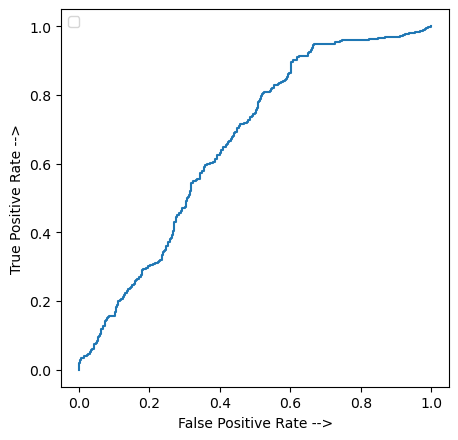

0.6613267543859649


In [7]:
allNormal = np.load("dev_test_pumpNormal.npy", allow_pickle=True)
allAnomaly = np.load("dev_test_pumpAnomaly.npy", allow_pickle=True)

test = allNormal[:]
test = test.tolist()

for i in allAnomaly:
    test.append(i)

print(len(test))

model = pickle.load(open('pump_1.pt', 'rb'))
criterion = nn.MSELoss()
lossDictionary = {}
val_acc = -1
val_loss = []
classifiers = []


# for data in tqdm(range(len(windows))):
#     window = torch.from_numpy(windows[data][0]).type(torch.float32)
#     output = model(window.view(-1,1,11,86))
#     loss = criterion(output.view(-1,1,11,86), window.view(-1,1,11,86))
#     val_loss.append(loss)
#     if lossDictionary.get(windows[data][1]) == None:
#         lossDictionary[windows[data][1]] = [loss.item()]
#     elif lossDictionary.get(windows[data][1]) != None:
#         lossDictionary[windows[data][1]].append(loss.item())
        
for data in tqdm(range(len(test))):
    windows, classifier = makeWindows4(test[data], numWindows)
    classifiers.append(classifier[0])
#     windows = np.array(windows)
    windows = torch.from_numpy(windows).type(torch.float32)
    output = model(windows.view(-1,1,11,10))
    mspec = reconstruct2(output.detach().numpy(), numWindows)
    loss = criterion(torch.from_numpy(mspec).type(torch.float32).view(-1,1,11,430), torch.from_numpy(test[data][0]).type(torch.float32).view(-1,1,11,430))
    val_loss.append(loss)
    lossDictionary[data] = loss.item()

val_loss = np.array(val_loss)
val_loss = val_loss * -1
fpr, tpr, thresholds = metrics.roc_curve(classifiers, val_loss)

#AUC-ROC Graph

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(fpr, tpr, linestyle='-')

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()
print(auc(fpr,tpr))

  2%|▏         | 27/1290 [00:00<00:04, 269.75it/s]

1290


100%|██████████| 1290/1290 [00:04<00:00, 271.07it/s]
No handles with labels found to put in legend.


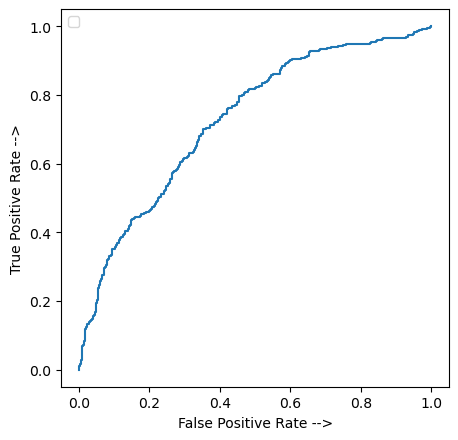

0.727570224719101


In [74]:
allNormal = np.load("dev_test_sliderNormal.npy", allow_pickle=True)
allAnomaly = np.load("dev_test_sliderAnomaly.npy", allow_pickle=True)

test = allNormal[:]
test = test.tolist()

for i in allAnomaly:
    test.append(i)

print(len(test))

model = pickle.load(open('slider_1.pt', 'rb'))
criterion = nn.MSELoss()
lossDictionary = {}
val_acc = -1
val_loss = []
classifiers = []


# for data in tqdm(range(len(windows))):
#     window = torch.from_numpy(windows[data][0]).type(torch.float32)
#     output = model(window.view(-1,1,11,86))
#     loss = criterion(output.view(-1,1,11,86), window.view(-1,1,11,86))
#     val_loss.append(loss)
#     if lossDictionary.get(windows[data][1]) == None:
#         lossDictionary[windows[data][1]] = [loss.item()]
#     elif lossDictionary.get(windows[data][1]) != None:
#         lossDictionary[windows[data][1]].append(loss.item())
        
for data in tqdm(range(len(test))):
    windows, classifier = makeWindows4(test[data], numWindows)
    classifiers.append(classifier[0])
#     windows = np.array(windows)
    windows = torch.from_numpy(windows).type(torch.float32)
    output = model(windows.view(-1,1,11,10))
    mspec = reconstruct2(output.detach().numpy(), numWindows)
    loss = criterion(torch.from_numpy(mspec).type(torch.float32).view(-1,1,11,430), torch.from_numpy(test[data][0]).type(torch.float32).view(-1,1,11,430))
    val_loss.append(loss)
    lossDictionary[data] = loss.item()

val_loss = np.array(val_loss)
val_loss = val_loss * -1
fpr, tpr, thresholds = metrics.roc_curve(classifiers, val_loss)

#AUC-ROC Graph

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(fpr, tpr, linestyle='-')

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()
print(auc(fpr,tpr))

In [75]:
thresholds

array([ -1.3143237,  -2.3143237,  -2.688535 ,  -2.8168647,  -2.8290496,
        -2.8840752,  -2.942102 ,  -2.9684296,  -2.9853127,  -2.9871886,
        -2.9876711,  -2.9959598,  -3.065513 ,  -3.0715551,  -3.1298463,
        -3.1508486,  -3.356582 ,  -3.3981445,  -3.4022696,  -3.4066842,
        -3.5171883,  -3.5578518,  -3.5836883,  -3.6026754,  -3.8565938,
        -3.8686762,  -4.0544558,  -4.0566187,  -4.114702 ,  -4.1191854,
        -4.2018847,  -4.2035813,  -4.233936 ,  -4.2421184,  -4.2782726,
        -4.322825 ,  -4.323852 ,  -4.3722343,  -4.3833284,  -4.4379735,
        -4.4570584,  -4.4697404,  -4.470732 ,  -4.471378 ,  -4.477452 ,
        -4.52555  ,  -4.550145 ,  -4.5875072,  -4.6074467,  -4.6121507,
        -4.682506 ,  -4.7209253,  -4.774246 ,  -4.798601 ,  -4.831212 ,
        -4.8383265,  -4.843539 ,  -4.85153  ,  -4.9777236,  -4.983541 ,
        -4.990725 ,  -5.013281 ,  -5.0575666,  -5.060257 ,  -5.1040626,
        -5.1079774,  -5.1189604,  -5.140072 ,  -5.202753 ,  -5.2

  0%|          | 0/2459 [00:00<?, ?it/s]

2459


100%|██████████| 2459/2459 [00:09<00:00, 256.12it/s]
No handles with labels found to put in legend.


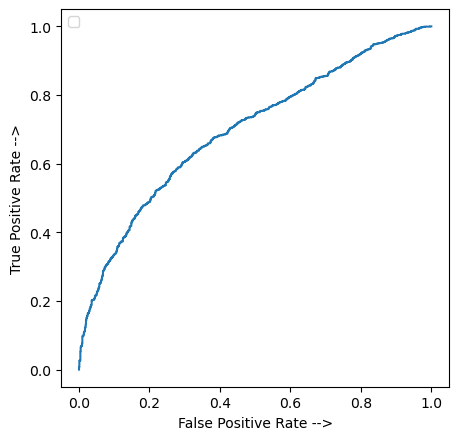

0.6968791312559018


In [9]:
allNormal = np.load("dev_test_ToyCarNormal.npy", allow_pickle=True)
allAnomaly = np.load("dev_test_ToyCarAnomaly.npy", allow_pickle=True)

test = allNormal[:]
test = test.tolist()

for i in allAnomaly:
    test.append(i)

print(len(test))

model = pickle.load(open('ToyCar_1.pt', 'rb'))
criterion = nn.MSELoss()
lossDictionary = {}
val_acc = -1
val_loss = []
classifiers = []


# for data in tqdm(range(len(windows))):
#     window = torch.from_numpy(windows[data][0]).type(torch.float32)
#     output = model(window.view(-1,1,11,86))
#     loss = criterion(output.view(-1,1,11,86), window.view(-1,1,11,86))
#     val_loss.append(loss)
#     if lossDictionary.get(windows[data][1]) == None:
#         lossDictionary[windows[data][1]] = [loss.item()]
#     elif lossDictionary.get(windows[data][1]) != None:
#         lossDictionary[windows[data][1]].append(loss.item())
        
for data in tqdm(range(len(test))):
    windows, classifier = makeWindows4(test[data], numWindows)
    classifiers.append(classifier[0])
#     windows = np.array(windows)
    windows = torch.from_numpy(windows).type(torch.float32)
    output = model(windows.view(-1,1,11,10))
    mspec = reconstruct2(output.detach().numpy(), numWindows)
    loss = criterion(torch.from_numpy(mspec).type(torch.float32).view(-1,1,11,430), torch.from_numpy(test[data][0]).type(torch.float32).view(-1,1,11,430))
    val_loss.append(loss)
    lossDictionary[data] = loss.item()

val_loss = np.array(val_loss)
val_loss = val_loss * -1
fpr, tpr, thresholds = metrics.roc_curve(classifiers, val_loss)

#AUC-ROC Graph

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(fpr, tpr, linestyle='-')

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()
print(auc(fpr,tpr))

  0%|          | 0/3509 [00:00<?, ?it/s]

3509


100%|██████████| 3509/3509 [00:14<00:00, 248.20it/s]
No handles with labels found to put in legend.


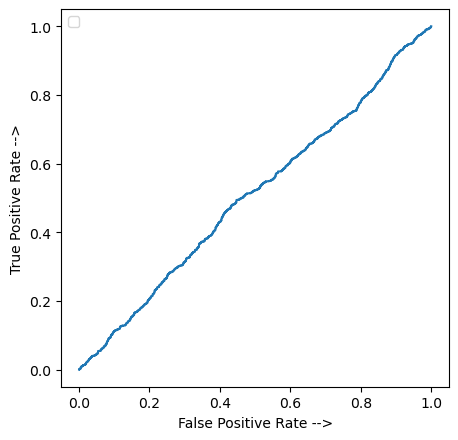

0.5069090349207064


In [10]:
allNormal = np.load("dev_test_ToyConveyorNormal.npy", allow_pickle=True)
allAnomaly = np.load("dev_test_ToyConveyorAnomaly.npy", allow_pickle=True)

test = allNormal[:]
test = test.tolist()

for i in allAnomaly:
    test.append(i)

print(len(test))

model = pickle.load(open('ToyConveyor_1.pt', 'rb'))
criterion = nn.MSELoss()
lossDictionary = {}
val_acc = -1
val_loss = []
classifiers = []


# for data in tqdm(range(len(windows))):
#     window = torch.from_numpy(windows[data][0]).type(torch.float32)
#     output = model(window.view(-1,1,11,86))
#     loss = criterion(output.view(-1,1,11,86), window.view(-1,1,11,86))
#     val_loss.append(loss)
#     if lossDictionary.get(windows[data][1]) == None:
#         lossDictionary[windows[data][1]] = [loss.item()]
#     elif lossDictionary.get(windows[data][1]) != None:
#         lossDictionary[windows[data][1]].append(loss.item())
        
for data in tqdm(range(len(test))):
    windows, classifier = makeWindows4(test[data], numWindows)
    classifiers.append(classifier[0])
#     windows = np.array(windows)
    windows = torch.from_numpy(windows).type(torch.float32)
    output = model(windows.view(-1,1,11,10))
    mspec = reconstruct2(output.detach().numpy(), numWindows)
    loss = criterion(torch.from_numpy(mspec).type(torch.float32).view(-1,1,11,430), torch.from_numpy(test[data][0]).type(torch.float32).view(-1,1,11,430))
    val_loss.append(loss)
    lossDictionary[data] = loss.item()

val_loss = np.array(val_loss)
val_loss = val_loss * -1
fpr, tpr, thresholds = metrics.roc_curve(classifiers, val_loss)

#AUC-ROC Graph

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(fpr, tpr, linestyle='-')

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()
print(auc(fpr,tpr))

879


100%|██████████| 879/879 [00:03<00:00, 230.10it/s]
No handles with labels found to put in legend.


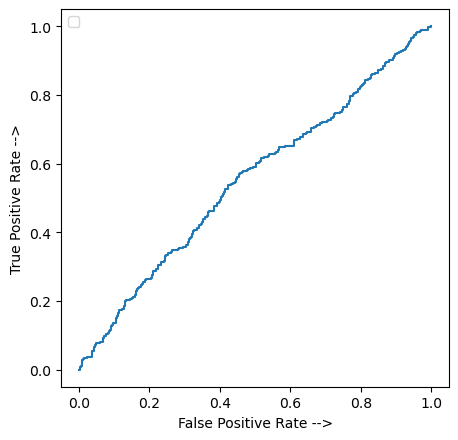

0.5506576200417537


In [95]:
allNormal = np.load("dev_test_valveNormal.npy", allow_pickle=True)
allAnomaly = np.load("dev_test_valveAnomaly.npy", allow_pickle=True)

test = allNormal[:]
test = test.tolist()

for i in allAnomaly:
    test.append(i)

print(len(test))

model = pickle.load(open('valve_1.pt', 'rb'))
criterion = nn.MSELoss()
lossDictionary = {}
val_acc = -1
val_loss = []
classifiers = []


# for data in tqdm(range(len(windows))):
#     window = torch.from_numpy(windows[data][0]).type(torch.float32)
#     output = model(window.view(-1,1,11,86))
#     loss = criterion(output.view(-1,1,11,86), window.view(-1,1,11,86))
#     val_loss.append(loss)
#     if lossDictionary.get(windows[data][1]) == None:
#         lossDictionary[windows[data][1]] = [loss.item()]
#     elif lossDictionary.get(windows[data][1]) != None:
#         lossDictionary[windows[data][1]].append(loss.item())

with torch.no_grad():
    for data in tqdm(range(len(test))):
        windows, classifier = makeWindows4(test[data], numWindows)
        classifiers.append(classifier[0])
#     windows = np.array(windows)
        windows = torch.from_numpy(windows).type(torch.float32)
        output = model(windows.view(-1,1,11,10))
        mspec = reconstruct2(output.detach().numpy(), numWindows)
        loss = criterion(torch.from_numpy(mspec).type(torch.float32).view(-1,1,11,430), torch.from_numpy(test[data][0]).type(torch.float32).view(-1,1,11,430))
        val_loss.append(loss)
        lossDictionary[data] = loss.item()

val_loss = np.array(val_loss)
val_loss = val_loss * -1
fpr, tpr, thresholds = metrics.roc_curve(classifiers, val_loss, pos_label = 1)

#AUC-ROC Graph

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(fpr, tpr, linestyle='-')

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()
print(auc(fpr,tpr))

In [51]:
min(val_loss)

-44.094395

In [60]:
thresholds

array([ -1.2106225,  -2.2106225,  -2.7954733,  -2.8825338,  -2.9039047,
        -3.0362413,  -3.4035354,  -3.6233475,  -3.6342008,  -3.636584 ,
        -3.6890237,  -3.7460916,  -3.7525263,  -3.8838637,  -3.9114954,
        -3.9341028,  -4.053594 ,  -4.076231 ,  -4.1511655,  -4.152345 ,
        -4.2079225,  -4.224404 ,  -4.258738 ,  -4.3534718,  -4.360371 ,
        -4.3742476,  -4.422552 ,  -4.443821 ,  -4.478816 ,  -4.499464 ,
        -4.5276375,  -4.61287  ,  -4.6295547,  -4.6624756,  -4.6739435,
        -4.674624 ,  -4.6832237,  -4.7015724,  -4.7049737,  -4.72336  ,
        -4.756791 ,  -4.766406 ,  -4.7734284,  -4.782757 ,  -4.823336 ,
        -4.82617  ,  -4.834211 ,  -4.855191 ,  -4.9031463,  -4.9107947,
        -4.9217696,  -4.931442 ,  -4.992534 ,  -5.0252476,  -5.0690355,
        -5.081938 ,  -5.089943 ,  -5.1023006,  -5.1220484,  -5.1281757,
        -5.1431437,  -5.1487813,  -5.1696444,  -5.171883 ,  -5.172196 ,
        -5.2042236,  -5.218584 ,  -5.2401857,  -5.2511077,  -5.2

In [12]:
#     correct = 0
# total = len(test)
# predictions = []
# #threshold = 10

# TPRs = []
# FPRS = []
# with torch.no_grad():
#     for threshold in range(0, 110, 10):
# #         TP = 0 #true positive
# #         TN = 0 #true negative
# #         FP = 0 # false positive
# #         FN = 0 # false negative
#         for j in tqdm(range(len(test))):
#             if lossDictionary[j] > threshold:
# #                 if [0,1] == classifiers[j].tolist():
#                 predictions.append([0,1])
# #                     TN += 1
# #                 else:
# #                     predictions[j] = [0,1]
# #                     FN += 1
#             elif lossDictionary[j] <= threshold:
# #                 if [1,0] == classifiers[j].tolist:
#                 predictions.append([1,0])
# #                     TP += 1
# #                 else:
# #                     predictions[j] = [1,0]
# #                     FP += 1
# #         TPR = TP / (TP+FN)
# #         FPR = FP / (FP+TN)
# #         TPRs.append(TPR)
# #         FPRs.append(FPR)

# #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# #https://www.projectpro.io/recipes/plot-roc-curve-in-python

# print(val_acc)

(11, 430)


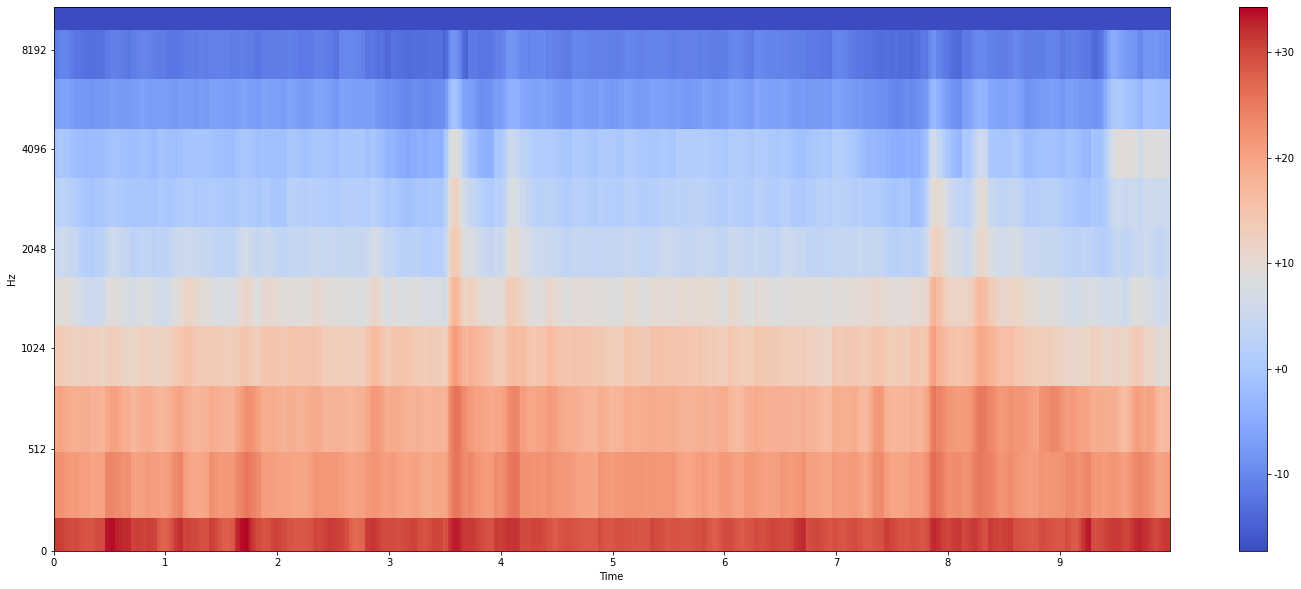

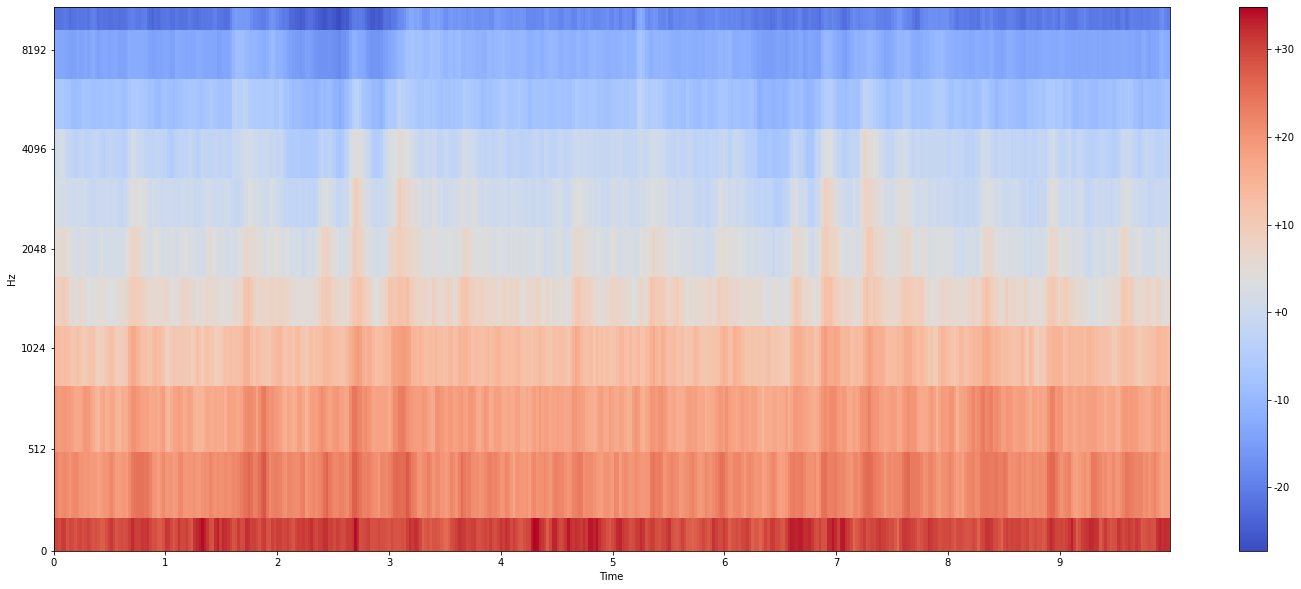

1.2222423553466797


In [100]:
machine = 'ToyConveyor'

allNormal = np.load(f'dev_test_{machine}Normal.npy', allow_pickle=True)
allAnomaly = np.load(f'dev_test_{machine}Anomaly.npy', allow_pickle=True)

a=4
model = pickle.load(open(f'{machine}_1.pt', 'rb'))
windows, classifier = makeWindows4(allAnomaly[a], numWindows)
windows = torch.from_numpy(windows).type(torch.float32)
o = model(windows.view(-1,1,11,10))
mspec = reconstruct2(o.detach().numpy(), numWindows)
print(mspec.shape)
plt.figure(figsize=(25,10))
librosa.display.specshow(mspec.reshape(11,430), x_axis = "time", y_axis = "mel", sr=22050)

plt.colorbar(format="%+2.f")
plt.show()

plt.figure(figsize=(25,10))
librosa.display.specshow(allNormal[a][0].reshape(11,430), x_axis = "time", y_axis = "mel", sr=22050)

plt.colorbar(format="%+2.f")
plt.show()

thing = criterion(torch.from_numpy(mspec).type(torch.float32).view(1,11,430), torch.from_numpy(allAnomaly[a][0]).type(torch.float32).view(-1,1,11,430))
# thing2 = criterion(torch.from_numpy(mspecWEIRD).type(torch.float32).view(1,11,430), torch.from_numpy(mspec).type(torch.float32).view(-1,1,11,430))
print(thing.item())
# print(thing2.item())
#25.00653648376465

In [35]:
np.save("weirdMSPEC.npy", mspec)


In [37]:
mspecWEIRD = np.load("weirdMSPEC.npy")

# thing = criterion(torch.from_numpy(mspecWEIRD).type(torch.float32).view(1,11,430), torch.from_numpy(mspec).type(torch.float32).view(-1,1,11,430))

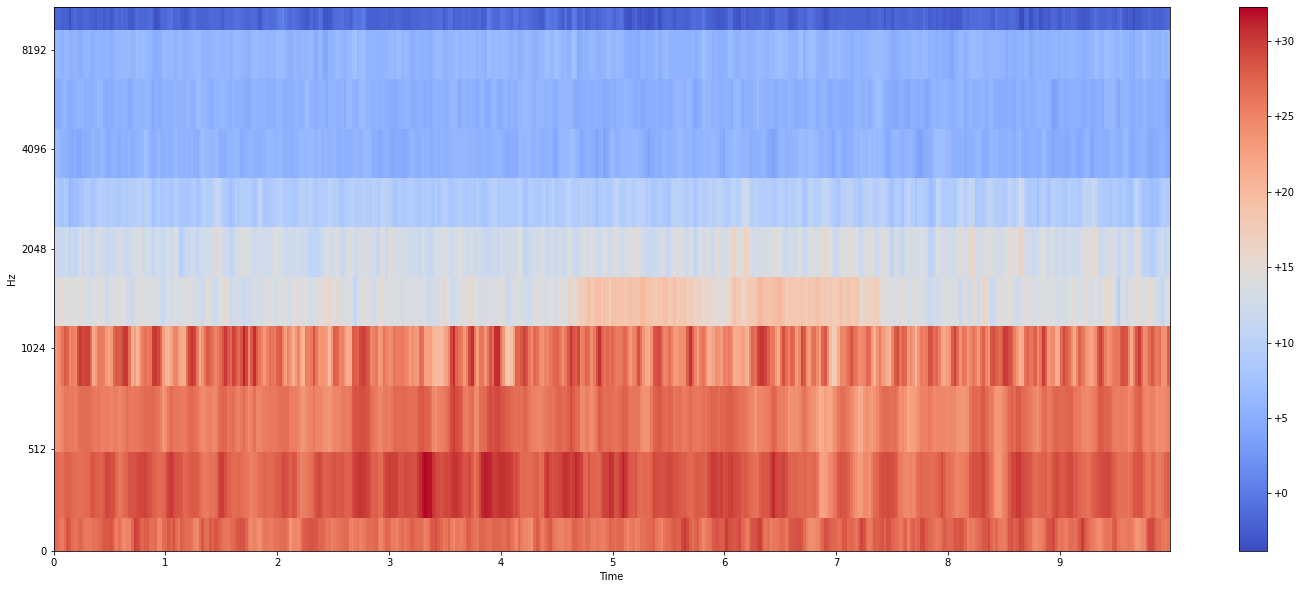

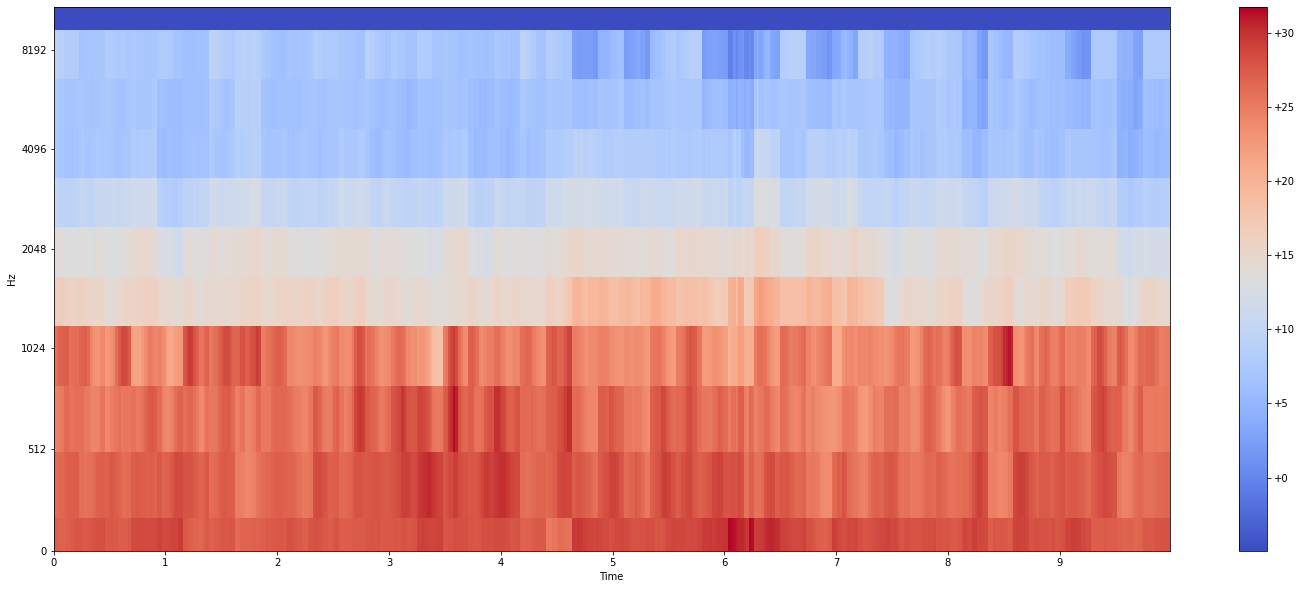

3.8681108951568604
[0 1]


In [102]:
machine = "fan"

allNormal = np.load(f"dev_test_{machine}Normal.npy", allow_pickle=True)
allAnomaly = np.load(f"dev_test_{machine}Anomaly.npy", allow_pickle=True)

a = 100

model = pickle.load(open(f'{machine}_1.pt', 'rb'))
windows, classifier = makeWindows4(allAnomaly[a], numWindows)
windows = torch.from_numpy(windows).type(torch.float32)
o = model(windows.view(-1,1,11,10))
mspec = reconstruct2(o.detach().numpy(), numWindows)

plt.figure(figsize=(25,10))
librosa.display.specshow(allAnomaly[a][0].reshape(11,430), x_axis = "time", y_axis = "mel", sr=22050)

plt.colorbar(format="%+2.f")
plt.show()

plt.figure(figsize=(25,10))
librosa.display.specshow(mspec.reshape(11,430), x_axis = "time", y_axis = "mel", sr=22050)

plt.colorbar(format="%+2.f")
plt.show()

thing = criterion(torch.from_numpy(mspec).type(torch.float32).view(1,11,430), torch.from_numpy(allAnomaly[a][0]).type(torch.float32).view(-1,1,11,430))
print(thing.item())
print(allAnomaly[a][1])

In [15]:
# a = 2
# w, c = makeWindows2(test[0:2], 5)
# output = model(torch.from_numpy(w[a][0]).type(torch.float32).view(-1,1,11,86))
# loss = criterion(output.view(-1,1,11,86), torch.from_numpy(w[a][0].reshape(-1,1,11,86)).type(torch.float32))
# print(loss.item())

In [16]:

# # def makeWindows2(data, numWindows):
# arr2 = makeWindows3(test[0:2], 5)
# whole = []

# for data in tqdm(range(len(arr2[0:5]))):
#     window = torch.from_numpy(np.array(arr2[data][0])).type(torch.float32)
#     output = model(window.view(-1,1,11,86))
#     whole.append([output, arr2[data][1], arr2[data][2]])

# wholeNumpy = np.array([[whole[0][0].detach().numpy().reshape(11,86), whole[0][1], whole[0][2]], [whole[1][0].detach().numpy().reshape(11,86), whole[1][1], whole[1][2]], [whole[2][0].detach().numpy().reshape(11,86), whole[2][1], whole[2][2]], [whole[3][0].detach().numpy().reshape(11,86), whole[3][1], whole[3][2]], [whole[4][0].detach().numpy().reshape(11,86), whole[4][1], whole[4][2]]])
# #     loss = criterion(output.view(-1,1,11,86), window.view(-1,1,11,86))
# melspec = reconstruct(np.array(wholeNumpy), 5, 1)
# melspec = np.array(melspec)

# plt.figure(figsize=(25,10))
# librosa.display.specshow(melspec.reshape(11,430), x_axis = "time", y_axis = "mel", sr=22050)

# plt.colorbar(format="%+2.f")
# plt.show()

# plt.figure(figsize=(25,10))
# librosa.display.specshow(test[0][0].reshape(11,430), x_axis = "time", y_axis = "mel", sr=22050)

# plt.colorbar(format="%+2.f")
# plt.show()
